In [61]:
from os import listdir
from os.path import isfile, join
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
from operator import itemgetter
import seaborn as sns
from sklearn.metrics.cluster import adjusted_mutual_info_score
import matplotlib.pyplot as plt


In [62]:
def Dice_Calculator(file1, file2):
    img1 = nib.load(file1)
    img1_data = img1.get_fdata()
    hdr1 = img1.header
    img1_flat = img1_data.flatten()
    img1_flat = [int(i) for i in img1_flat]

    img2 = nib.load(file2)
    img2_data = img2.get_fdata()
    hdr2 = img2.header
    img2_flat = img2_data.flatten()
    img2_flat = [int(i) for i in img2_flat]
    
    values1 = np.unique(img1_flat)
    values2 = np.unique(img2_flat)
    counts1 = np.array(range(1, len(img1_flat)+1))
    counts2 = np.array(range(1, len(img2_flat)+1))
    counts1 = [int(i) for i in counts1]
    counts2 = [int(i) for i in counts2]

    img1_flatten = list(zip(img1_flat, counts1))
    img2_flatten = list(zip(img2_flat, counts2))

    img1_flatten = sorted(img1_flatten, key = lambda l:l[0])
    img2_flatten = sorted(img2_flatten, key = lambda l:l[0])
    
    img1_cell = [[] for i in range(len(values1))]
    img2_cell = [[] for i in range(len(values2))]
    start = 0
    for i in range(0,len(values1)-1):
        img1_list = [x[0] for x in img1_flatten]
        end = max(loc for loc, val in enumerate(img1_list) if val == values1[i])
        for j in range(start,end):
            img1_cell[i].append(img1_flatten[j][1])  
        start = end+1

    start = 0
    for i in range(0,len(values2)-1):
        img2_list = [x[0] for x in img2_flatten]
        end = max(loc for loc, val in enumerate(img2_list) if val == values2[i])
        for j in range(start,end):
            img2_cell[i].append(img2_flatten[j][1])  
        start = end+1
        
    Dice_scores = np.zeros((len(values1),len(values2)),dtype=float)
    for i in range(0,len(values1)-1):
        for j in range(0,len(values2)-1):
            sims = len(set(img1_cell[i]) & set(img2_cell[j]))
            Dice_scores[i][j] = 2*sims/(len(img1_cell[i])+len(img2_cell[j]))
    
    mean_Dice = Dice_scores.mean()
    #return mean_Dice
    return Dice_scores

In [2]:
def NMI_Calculator(file1,file2):
    img1 = nib.load(filename1)
    img1_data = img1.get_fdata()
    img1_flat = img1_data.flatten()
    img1_flat = img1_flat+1
    img1_flat.tolist()
    img1_flat = [int(i) for i in img1_flat]

    img2 = nib.load(filename2)
    img2_data = img2.get_fdata()
    img2_flat = img2_data.flatten()
    img2_flat = img2_flat+1
    img2_flat.tolist()
    img2_flat = [int(i) for i in img2_flat]

    nmi = adjusted_mutual_info_score(img1_flat, img2_flat)
    return nmi
    

In [ ]:
mypath = '../Nifti_images'
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
[f for f in files if 'DS' not in f]
Dice_scores = np.zeros((len(files)-1,len(files)-1),dtype=float)

for i in range(0,len(files)-2):
    for j in range(i,len(files)-1):
        image1_name = files[i]
        filename1 = join(mypath, image1_name)
        image2_name = files[j]
        filename2 = join(mypath, image2_name)

        Dice_scores[i][j] = Dice_Calculator(filename1, filename2)

sns.heatmap(Dice_scores)

In [39]:
mypath = '../Nifti_images'
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
files = [f for f in files if 'DS' not in f]
files = [f for f in files if 'glasser' not in f]
files = [f for f in files if 'pp264' not in f]
NMI_scores = np.zeros((len(files)-1,len(files)-1),dtype=float)

for i in range(0,len(files)-2):
    for j in range(i,len(files)-1):
        image1_name = files[i]
        filename1 = join(mypath, image1_name)
        image2_name = files[j]
        filename2 = join(mypath, image2_name)
        print(i)
        NMI_scores[i][j] = NMI_Calculator(filename1, filename2)

#sns.heatmap(NMI_scores)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
10
10
10
10
10
10
11
11
11
11
11
11
11
11
11
11
11
11
12
12
12
12
12
12
12
12
12
12
12
13
13
13
13
13
13
13
13
13
13
14
14
14
14
14
14
14
14
14
15
15
15
15
15
15
15
15
16
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
19
19
19
19
20
20
20
21
21


In [63]:
mypath = '../Nifti_images'
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
files
file1 = 'JHU_space-MNI152NLin6_res-1x1x1.nii.gz'
file2 = 'HarvardOxfordcort-maxprob-thr25_space-MNI152NLin6_res-1x1x1.nii.gz'
filename1 = join(mypath, file1)
filename2 = join(mypath, file2)
Dice = Dice_Calculator(filename1,filename2)

Text(0.5,1,'DICE Score Map between JHU and HOC atlases')

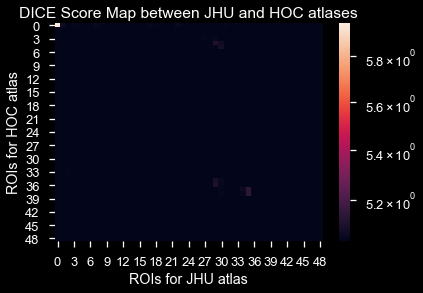

In [78]:
from matplotlib.colors import LogNorm

Dice = Dice+0.01
sns.heatmap(Dice,
            #cbar_kws={'ticks':[2,3]}, #Can't specify because seaborn does
            norm=LogNorm(vmin=Dice.min(), vmax=Dice.max()))
plt.xlabel('ROIs for JHU atlas')
plt.ylabel('ROIs for HOC atlas')
plt.title('DICE Score Map between JHU and HOC atlases')

In [81]:
mypath = '../Nifti_images'
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
files
file1 = 'JHU_space-MNI152NLin6_res-1x1x1.nii.gz'
file2 = 'JHU_space-MNI152NLin6_res-1x1x1.nii.gz'
filename1 = join(mypath, file1)
filename2 = join(mypath, file2)
Dice = Dice_Calculator(filename1,filename2)

Text(0.5,1,'DICE Score Map between JHU and itself')

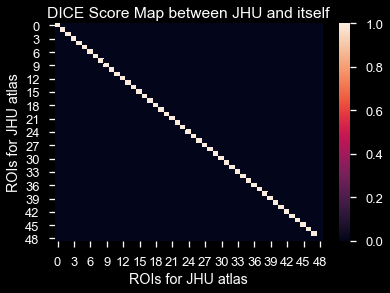

In [84]:
sns.heatmap(Dice)
plt.xlabel('ROIs for JHU atlas')
plt.ylabel('ROIs for JHU atlas')
plt.title('DICE Score Map between JHU and itself')

In [48]:
backup = np.load('NMI.npy')

In [56]:
mypath = '../Nifti_images'
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
files = [f for f in files if 'DS' not in f]
files = [f for f in files if 'glasser' not in f]
files = [f for f in files if 'pp264' not in f]
files = [f.split('_')[0] for f in files]
files[5] = 'HOC'
files[6] = 'HOS'
files[9] = 'Princeton'
files[10] = 'Schaefer-1000'
files[11] = 'Schaefer-200'
files[12] = 'Schaefer-300'
files[13] = 'Schaefer-400'
files

['aal',
 'brodmann',
 'CPAC200',
 'desikan',
 'DKT',
 'HOC',
 'HOS',
 'hemispheric',
 'JHU',
 'Princeton',
 'Schaefer-1000',
 'Schaefer-200',
 'Schaefer-300',
 'Schaefer-400',
 'Schaefer2018',
 'Schaefer2018',
 'slab1068',
 'slab907',
 'Talairach',
 'tissue',
 'yeo-17-liberal',
 'yeo-17',
 'yeo-7-liberal',
 'yeo-7']

(23, 23)


(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21.]),
 <a list of 22 Text yticklabel objects>)

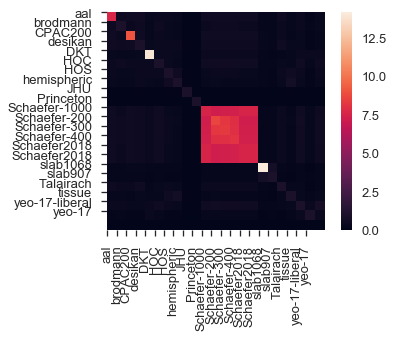

In [57]:
sns.set(style="ticks", context="talk")
fig, ax = plt.subplots()
plt.style.use("dark_background")

NMI_scores = backup

for i in range(22):
    for j in range(i, 22):
        NMI_scores[j][i] = NMI_scores[i][j]
print(NMI_scores.shape)
        
with sns.axes_style("white"):
    ax = sns.heatmap(NMI_scores, square=True)
    
plt.xticks(np.arange(0, 22, 1.0))
plt.yticks(np.arange(0,22,1.0))
    
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = files

ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

plt.xticks(rotation=90)
plt.yticks(rotation=0)